In [ ]:
import os
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model

def extract_faces(image_path):
    # Load an image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces in the image
    detector = MTCNN()
    faces = detector.detect_faces(image_rgb)

    return faces, image_rgb

def get_face_vector(face_image):
    # Load pre-trained ResNet50 model + higher level layers
    base_model = ResNet50(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

    # Preprocess the face image for ResNet50 model
    face_image_resized = cv2.resize(face_image, (224, 224))
    face_array = img_to_array(face_image_resized)
    face_array = np.expand_dims(face_array, axis=0)
    face_array = preprocess_input(face_array)

    # Extract face vector
    face_vector = model.predict(face_array)
    return face_vector.flatten()

def main():
    dir_path = './test_images'
    detect_path = './test_images_detect'
    
    # 创建保存检测到人脸的目录
    if not os.path.exists(detect_path):
        os.makedirs(detect_path)
    
    output_file = '/tmp/face2048.txt'
    
    with open(output_file, 'w') as f:
        for file_name in os.listdir(dir_path):
            if file_name.lower().endswith('.png'):
                image_path = os.path.join(dir_path, file_name)
                faces, image_rgb = extract_faces(image_path)

                for i, face in enumerate(faces):
                    x, y, width, height = face['box']
                    face_image = image_rgb[y:y+height, x:x+width]

                    # Save the detected face image
                    face_file_name = f"{os.path.splitext(file_name)[0]}_face_{i}.png"
                    face_file_path = os.path.join(detect_path, face_file_name)
                    cv2.imwrite(face_file_path, cv2.cvtColor(face_image, cv2.COLOR_RGB2BGR))

                    # Get the face vector
                    face_vector = get_face_vector(face_image)
                    face_vector_str = ','.join(map(str, face_vector))
                    f.write(f'{file_name}; {face_vector_str}; {file_name}\n')


In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
# create table --name=face_table --partition_num=1 --replica_num=1 --dim=2048
# load --table=face_table --file=/tmp/face2048.txt
# build index --table=face_table --annoy_tree_num=10
# getknn --table=face_table --key=2.png --limit=10
# quit

In [1]:
import os
import cv2
from matplotlib import pyplot as plt

def show_image(image_path):
    # 读取图片
    image = cv2.imread(image_path)
    
    # 转换图片颜色从 BGR 到 RGB (因为 OpenCV 默认使用 BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 使用 matplotlib 显示图片
    plt.imshow(image_rgb)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

def show_all_png_images(path):
    # 检查路径是否有效
    if not os.path.isdir(path):
        print(f"{path} is not a valid directory path")
        return
    
    # 遍历目录中的所有文件
    for root, _, files in os.walk(path):
        for file in files:
            if file.lower().endswith('.png'):
                image_path = os.path.join(root, file)
                print(file)
                show_image(image_path)

In [ ]:
print("原始图片:")
directory_path = './test_images'
show_all_png_images(directory_path)

print("抠脸图片:")
directory_path = './test_images_detect'
show_all_png_images(directory_path)


查询的照片：



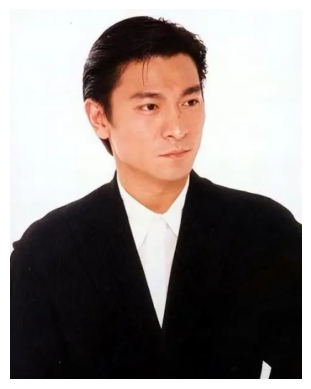

Response code: 0
{distance:0.000000, key:2.png, attach_value:2.png}
{distance:0.486304, key:1.png, attach_value:1.png}
{distance:0.497091, key:8.png, attach_value:8.png}
{distance:0.521643, key:4.png, attach_value:4.png}
{distance:0.554424, key:6.png, attach_value:6.png}
{distance:0.612594, key:9.png, attach_value:9.png}
{distance:0.622133, key:3.png, attach_value:3.png}
{distance:0.628709, key:7.png, attach_value:7.png}
{distance:0.651623, key:11.png, attach_value:11.png}
{distance:0.720183, key:10.png, attach_value:10.png}
相似的图片：



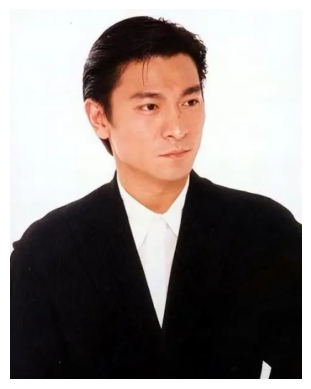

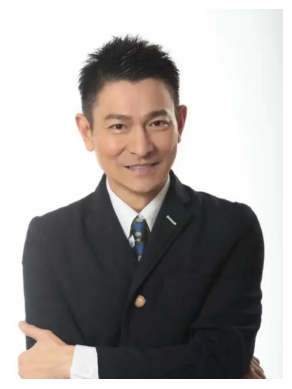

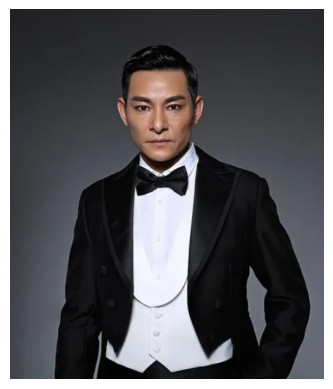

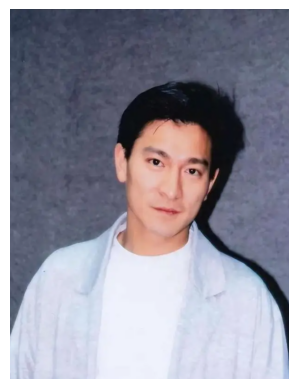

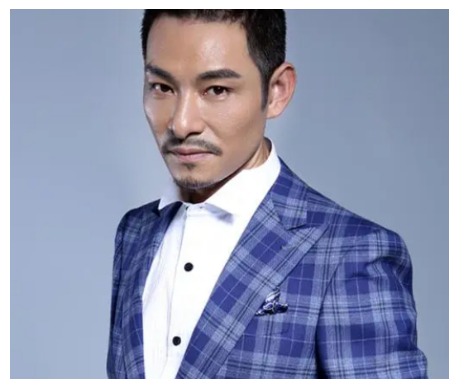

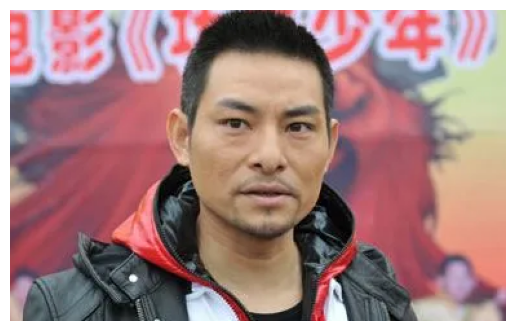

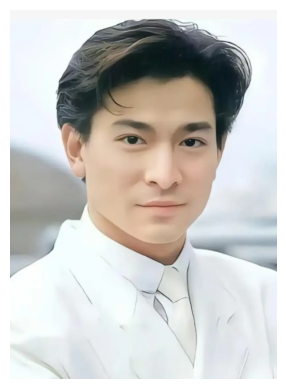

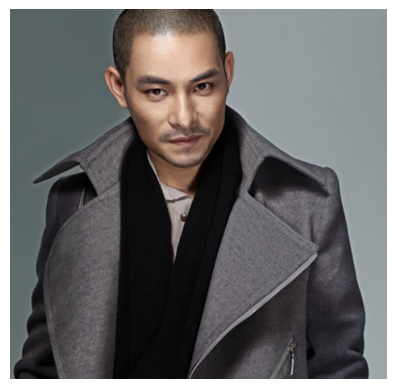

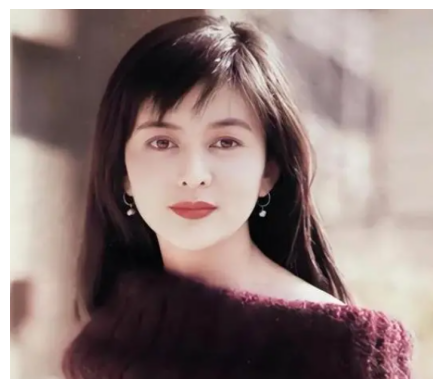

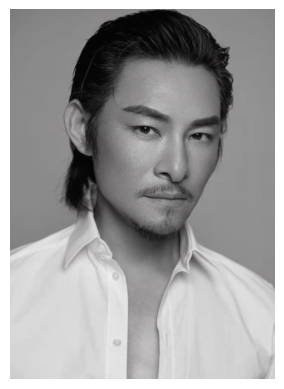

In [2]:
import sys
import os

# 将 vdb_module.so 的目录添加到 sys.path
sys.path.append('/home/mhlee/Work/dev/vraft/output/libs')

import vdb_module

# 创建 VdbEngine 实例
engine = vdb_module.VdbEngine("/tmp/local_console")

table = "face_table"
key='2.png'
limit = 10

print("查询的照片：\n")
show_image('./test_images/' + key)
res_code, results = engine.get_knn_by_key(table, key, limit)



print("Response code:", res_code)
for result in results:
    print(result.to_print_string())

print("相似的图片：\n")
for result in results:
    show_image('./test_images/' + result.attach_value)


del engine